### Elevation profiles extracted from SRTM over Mt Baker compared with ICESat-2

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
%matplotlib inline
from geopandas import GeoSeries
import os
import h5py
from shapely.geometry import Point,Polygon
import glob
from rasterio import features
from topolib import gda_lib

### Read reference DEM

In [2]:
dem_fn = '/home/jovyan/data/srtm_elevation/SRTM3/cache/srtm_wa_subset.vrt'
ds = rasterio.open(dem_fn)

### Read ATL06 data

In [3]:
data_dir = '/home/jovyan/data/nsidc/**/'
ATL06_list = sorted(glob.glob(data_dir + "*.h5"))

In [4]:
ATL06_fn = ATL06_list[0]

dataset_dict={'land_ice_segments':['h_li',
                                   'delta_time',
                                   'longitude',
                                   'latitude'],
              'land_ice_segments/ground_track':['x_atc']}

In [5]:
ATL06_gdf = gda_lib.ATL06_2_gdf(ATL06_fn,dataset_dict)
ATL06_gdf = ATL06_gdf.to_crs(ds.crs)

In [6]:
dem = ds.read(1)
dem = np.ma.masked_equal(dem,gda_lib.get_ndv(ds))

In [16]:
xmin,ymin,xmax,ymax = ds.bounds
extent = ds.bounds

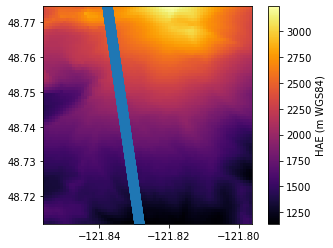

In [18]:
fig,ax = plt.subplots()
im = ax.imshow(dem,cmap='inferno',extent=[xmin,xmax,ymin,ymax])
plt.colorbar(im,label='HAE (m WGS84)')
ATL06_gdf.plot(ax=ax)
# ax.set_extent(extent)

In [19]:
bbox = ds.bounds

In [41]:
def dem2polygon(dem_file_name):
    """
        Take DEM and return polygon geodataframe matching the extent and coordinate system of the input DEM.
        
        Input parameters:
        dem_file_name: Absolute path to a DEM file
        
        Output parameters:
        dem_polygon: A polygon geodataframe matching the extent and coordinate system of the input DEM.

    """
    
    # read in dem using rasterio
    dem = rasterio.open(dem_file_name)
    
    # extact total bounds of dem
    bbox = dem.bounds
    
    # convert to corner points
    p1 = Point(bbox[0], bbox[3])
    p2 = Point(bbox[2], bbox[3])
    p3 = Point(bbox[2], bbox[1])
    p4 = Point(bbox[0], bbox[1])
    
    # extract corner coordinates
    np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
    np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
    np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
    np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])
    
    # convert to polygon
    bb_polygon = Polygon([np1, np2, np3, np4])

    # create geodataframe
    dem_polygon_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=['geometry'])
    
    dem_polygon_gdf.crs = dem.crs
    
    return dem_polygon_gdf


In [42]:
poly = dem2polygon(dem_fn)

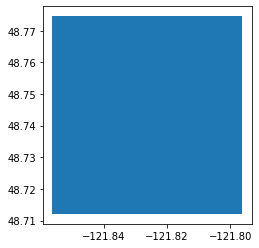

In [43]:
poly.plot()

In [36]:
glas_gdf_aea_rgi = gpd.sjoin(ATL06_gdf, df2, op='intersects', how='inner')

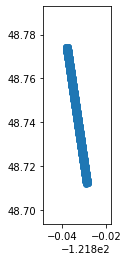

In [38]:
glas_gdf_aea_rgi.plot()